# Data Story Notebook
This is the Jupyter notebook for the 'Data Story' portion of my first Springboard capstone project. The goal of this project is to create a model that predicts what decade a song is form based on its lyrical content. This will be where I do my exploratory data analysis of the lyrical content of the lyrics of the songs, and of the data in general.

In [34]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.util import ngrams
import seaborn as sns
import nltk
import os
sns.set()

To start with, we will import the data and visualize large parts of the data. Insteresting things to look at will be numbers of songs per year, most common artists, and most common words from songs overall and by decades. We will start with looking at the biggest possible pictures in the data.

In [35]:
# importing the data
songs = pd.read_csv("clean_songs.csv")
songs = songs.drop(columns='Unnamed: 0')
songs.head()

,Rank,Song,Artist,Year,Lyrics,Decade
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,1960
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1960
2,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,1960
3,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,1960
4,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,1960


# Looking at the Big Picture
Cleaning the data resulted in dropping a few songs from each year so the first few things we will look at is counting what is going on with the data overall. how many songs do we have for each year? for each rank?

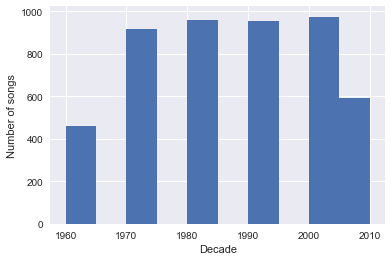

In [36]:
# visualizing songs per year
plt.hist(songs['Decade'])
plt.xlabel('Decade')
plt.ylabel('Number of songs')
plt.show()

Looking at this graph, we see that we have not lost too many songs from each decade after cleaning the data. The most obvious discrepencies we can observe here are that the 1960's has a bit less than 500 songs, and the 2010's have a bit less than 600 songs. These are both expected from how the data was originally constructed, with the years 1965-2015.

In [37]:
songs.groupby('Rank').size().head(20)

Rank
1     48
2     46
3     48
4     51
5     49
6     50
7     48
8     49
9     49
10    49
11    49
12    50
13    50
14    49
15    48
16    46
17    50
18    49
19    50
20    48
dtype: int64

Looking at counts of the top twenty ranks, we see that the top twenty ranks have not been too adversely affected by the data cleaning procedure. I can observe that rank 4 has 51 songs for some reason, which is an interesting error in the data. Fortunately only a two of the first 20 ranks are missing more than two or three songs.

In [38]:
top_art = songs.groupby('Artist').size().sort_values(ascending=False).head(10)
top_art

Artist
madonna            34
elton john         25
mariah carey       24
janet jackson      22
michael jackson    22
stevie wonder      20
rihanna            19
whitney houston    19
taylor swift       19
the beatles        17
dtype: int64

Viewing the most common artists and when they were popular may be interesting, as the fact that some artitsts completely dominate charts and my have their own lyrical styles may affect the lyrical content of certain decades.

# Breaking it down
Now we are going to start breaking down to data into its minutia in order to start making observations of lyrical content. We will be looking at lyrical content as a whole, then by decade.

The following functions are functions that will be used to process the data in the rest of the document.

In [40]:
# To start with, we will tokenize the lyrics and preprocess the words, removing stopwords and non alphabetical terms
def preprocess(string):
    """Tokenizes and lowercases a string, removing non-alpha words and stop words."""    
    tok = word_tokenize(string)
    tok = [t.lower() for t in tok]
    tok = [t for t in tok if t.isalpha()]
    stop_words = stopwords.words('english')
    data_stops = ['im', 'dont', 'youre', 'na', 'oh', 'ill']
    tok = [t for t in tok if t not in stop_words]
    tok = [t for t in tok if t not in data_stops]
    return tok

# This function tokenizes without removing stopwords
def withstop(string):
    """Tokenizes without removing stopwords"""
    tok = word_tokenize(string)
    tok = [t.lower() for t in tok]
    tok = [t for t in tok if t.isalpha()]
    return tok

In [42]:
# A function to create n gram dataframes
def n_grammer(tokens, n):
    """takes the tokens as they are formatted in the dataframe and returns a new data frame of n-grams"""
    counts = dict()
    for song in tokens:
        n_grams = ngrams(song, n)
        grams = [ ' '.join(g) for g in n_grams]
        for word in grams:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1
    counts_df =  pd.DataFrame.from_dict(counts, orient='index', columns=['counts'])
    counts_df = counts_df.sort_values(by='counts', ascending=False)
    return counts_df

In [43]:
#A function that generates wordcount dataframes
def wordcounts(data):
    """Takes a list of lists of words and generates a word counter from those tokens."""
    counts = dict()
    for song in data:
        words = song
        for word in words:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1
    counts_df =  pd.DataFrame.from_dict(counts, orient='index', columns=['counts'])
    counts_df = counts_df.sort_values(by='counts', ascending=False)
    return counts_df

In [44]:
# Creating a tokens column for the data
songs['Tokens'] = songs['Lyrics'].apply(preprocess)

# Also creating without stop words
songs['WithStops'] = songs['Lyrics'].apply(withstop)

In [46]:
#calculating wordcounts for all of the words in the data
all_words = wordcounts(songs['Tokens'])
all_words.head(10)

,counts
love,15292
know,11168
like,10949
got,10215
baby,9100
get,8265
yeah,6259
want,6214
go,6108
make,5520


In [51]:
# also looking at wordcounts with the data that still have stopwords
all_stops = wordcounts(songs['WithStops'])
all_stops.head(10)

,counts
you,64615
i,56513
the,53427
to,35752
and,32555
me,31648
a,29283
it,25695
my,22822
in,18555


In [52]:
#defining some variables so that they can be used later in the code more efficiently
six = songs[songs.Decade==1960]
sev = songs[songs.Decade==1970]
eig = songs[songs.Decade==1980]
nin = songs[songs.Decade==1990]
aut = songs[songs.Decade==2000]
ten = songs[songs.Decade==2010]

In [55]:
#Calculating wordcounts for each of the decades respectively
sixties= wordcounts(six['Tokens'])
seventies = wordcounts(sev['Tokens'])
eighties = wordcounts(eig['Tokens'])
nineties = wordcounts(nin['Tokens'])
auts = wordcounts(aut['Tokens'])
teens = wordcounts(ten['Tokens'])

#calculating word count values with the stopwords
sixties_st= wordcounts(six['WithStops'])
seventies_st = wordcounts(sev['WithStops'])
eighties_st = wordcounts(eig['WithStops'])
nineties_st = wordcounts(nin['WithStops'])
auts_st = wordcounts(aut['WithStops'])
teens_st = wordcounts(ten['WithStops'])

In [54]:
sixties.head(10)

,counts
love,1176
baby,783
know,507
got,496
come,408
yeah,387
get,342
see,334
like,333
girl,322


In [28]:
seventies.head(10)

,counts
love,2946
got,1332
baby,1266
get,1245
know,1173
like,1019
come,815
time,764
yeah,746
cant,706


In [29]:
eighties.head(10)

,counts
love,3265
know,1942
got,1513
baby,1405
like,1232
time,1179
want,1159
gon,1002
get,991
yeah,976


In [30]:
nineties.head(10)

,counts
love,3479
know,2476
baby,2204
like,2102
got,1886
get,1719
want,1644
yeah,1567
go,1343
make,1323


In [31]:
auts.head(10)

,counts
like,3880
know,3502
got,3243
get,2801
love,2657
baby,2095
go,1894
girl,1875
make,1713
want,1705


In [32]:
teens.head(10)

,counts
like,2383
love,1769
got,1745
know,1568
baby,1347
get,1167
yeah,1137
go,1040
wan,931
gon,923


In [ ]:
songs[songs.Decade==1960]['Tokens']

After observing the most common word counts of years without stop words, it seems the ten most common words for each decade are very similar. Now we will look at N grams for each of the decades as well as the top n grams for all decades.


In [ ]:
#calculating n=2 grams for data without stopwords
sixties= n_grammer(six['Tokens'], 2)
seventies = n_grammer(sev['Tokens'], 2)
eighties = n_grammer(eig['Tokens'], 2)
nineties = n_grammer(nin['Tokens'], 2)
auts = n_grammer(aut['Tokens'], 2)
teens = n_grammer(ten['Tokens'], 2)

#calculating m=2grams for data with stopwords
sixties_st= wordcounts(six['WithStops'])
seventies_st = wordcounts(sev['WithStops'])
eighties_st = wordcounts(eig['WithStops'])
nineties_st = wordcounts(nin['WithStops'])
auts_st = wordcounts(aut['WithStops'])
teens_st = wordcounts(ten['WithStops'])

In [39]:
def preprocess(string):
    """Tokenizes, and lowercases a string, removing non-alpha words."""    
    tok = word_tokenize(string)
    tok = [t.lower() for t in tok]
    tok = [t for t in tok if t.isalpha()]
    stop_words = stopwords.words('english')
    tok = [t for t in tok if t not in stop_words]
    return tok

In [33]:
# Before taking apart data, split it into decades
sixt = songs[songs.Decade == 1960]
sevt = songs[songs.Decade == 1970]
eightt = songs[songs.Decade == 1980]
ninett = songs[songs.Decade == 1990]
auts = songs[songs.Decade == 2000]
teens = songs[songs.Decade == 2010]

In [34]:
six_lyr = sixt['Lyrics']
tes = six_lyr[0]
bow = Counter(word_tokenize(tes))
bow.most_common(10)

[('wooly', 18),
 ('bully', 17),
 ('the', 8),
 ('matty', 3),
 ('told', 3),
 ('hatty', 3),
 ('a', 3),
 ('and', 3),
 ('lets', 3),
 ('to', 3)]